# Project PCD 2025 Kelompok 18
## Klasifikasi Kangker Kulit Jinak Dan Ganas
Zainul Majdi (F1D02310028)

Mustofa Arif (F1D02310083)

Apriesna Zulhan (F1D02310100)

Lalu Maulana Rizki Hidayat (F1D02310118)

# Project Overview

# Import Library

In [31]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

## Data Loading

In [32]:
data = []
labels = []
file_name = []
for sub_folder in os.listdir("dataset"):
    sub_folder_files = os.listdir(os.path.join("dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        
        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)


## Data Preparation

### Define Preprocessing Function


In [33]:
def resize(img, new_width, new_height):
    h, w = img.shape
    resized = np.zeros((new_height, new_width), dtype=np.uint8)

    for i in range(new_height):
        for j in range(new_width):
            x = int(j * w / new_width)
            y = int(i * h / new_height)
            resized[i, j] = img[y, x]
    
    return resized

def median_filter(image,baris,kolom):
    tengah = int(baris*kolom/2)
    hasil = np.zeros(image.shape)
    _baris = int((baris-1)/2)
    _kolom = int((kolom-1)/2)
    _image = np.pad(image,((_baris,_baris),(_kolom,_kolom)),mode='edge')
    for i in range (hasil.shape[0]):
        for j in range (hasil.shape[1]):
            Median = np.zeros(baris*kolom)
            m=0
            for k in range (i,i+baris):
                for l in range (j,j+kolom):
                    Median[m]=_image[k,l]
                    m+=1
            Median.sort()
            a = Median[tengah]
            b = Median[tengah-1]
            _Median = int(a+b)/2
            hasil[i,j] =_Median
    return hasil

def histogram_equalization(img_gray):
    hist, bins = np.histogram(img_gray.flatten(), bins=256, range=[0,255])
    cdf = hist.cumsum()
    cdf_normalized = cdf * 255 / cdf[-1]
    img_eq = np.interp(img_gray.flatten(), bins[:-1], cdf_normalized)
    return img_eq.reshape(img_gray.shape).astype(np.uint8)

def normalize_min_max(image):
    min_val = np.min(image)
    max_val = np.max(image)
    if max_val == min_val:
        return np.zeros_like(image, dtype=np.uint8)  # atau isi dengan nilai tetap
    norm = (image - min_val) / (max_val - min_val)
    return (norm * 255).astype(np.uint8)

def threshold(image, nilai_ambang):
    tinggi_gambar, lebar_gambar = image.shape
    hasil_biner = np.zeros((tinggi_gambar, lebar_gambar), dtype=np.uint8)

    for baris in range(tinggi_gambar):
        for kolom in range(lebar_gambar):
            if image[baris, kolom] <= nilai_ambang:
                hasil_biner[baris, kolom] = 255
            else:
                hasil_biner[baris, kolom] = 0

    return hasil_biner

def morphological_opening(image):
    kernel = np.ones((3, 3), np.uint8)
    opened = cv.morphologyEx(image, cv.MORPH_OPEN, kernel)
    
    return opened

### Preprocessing

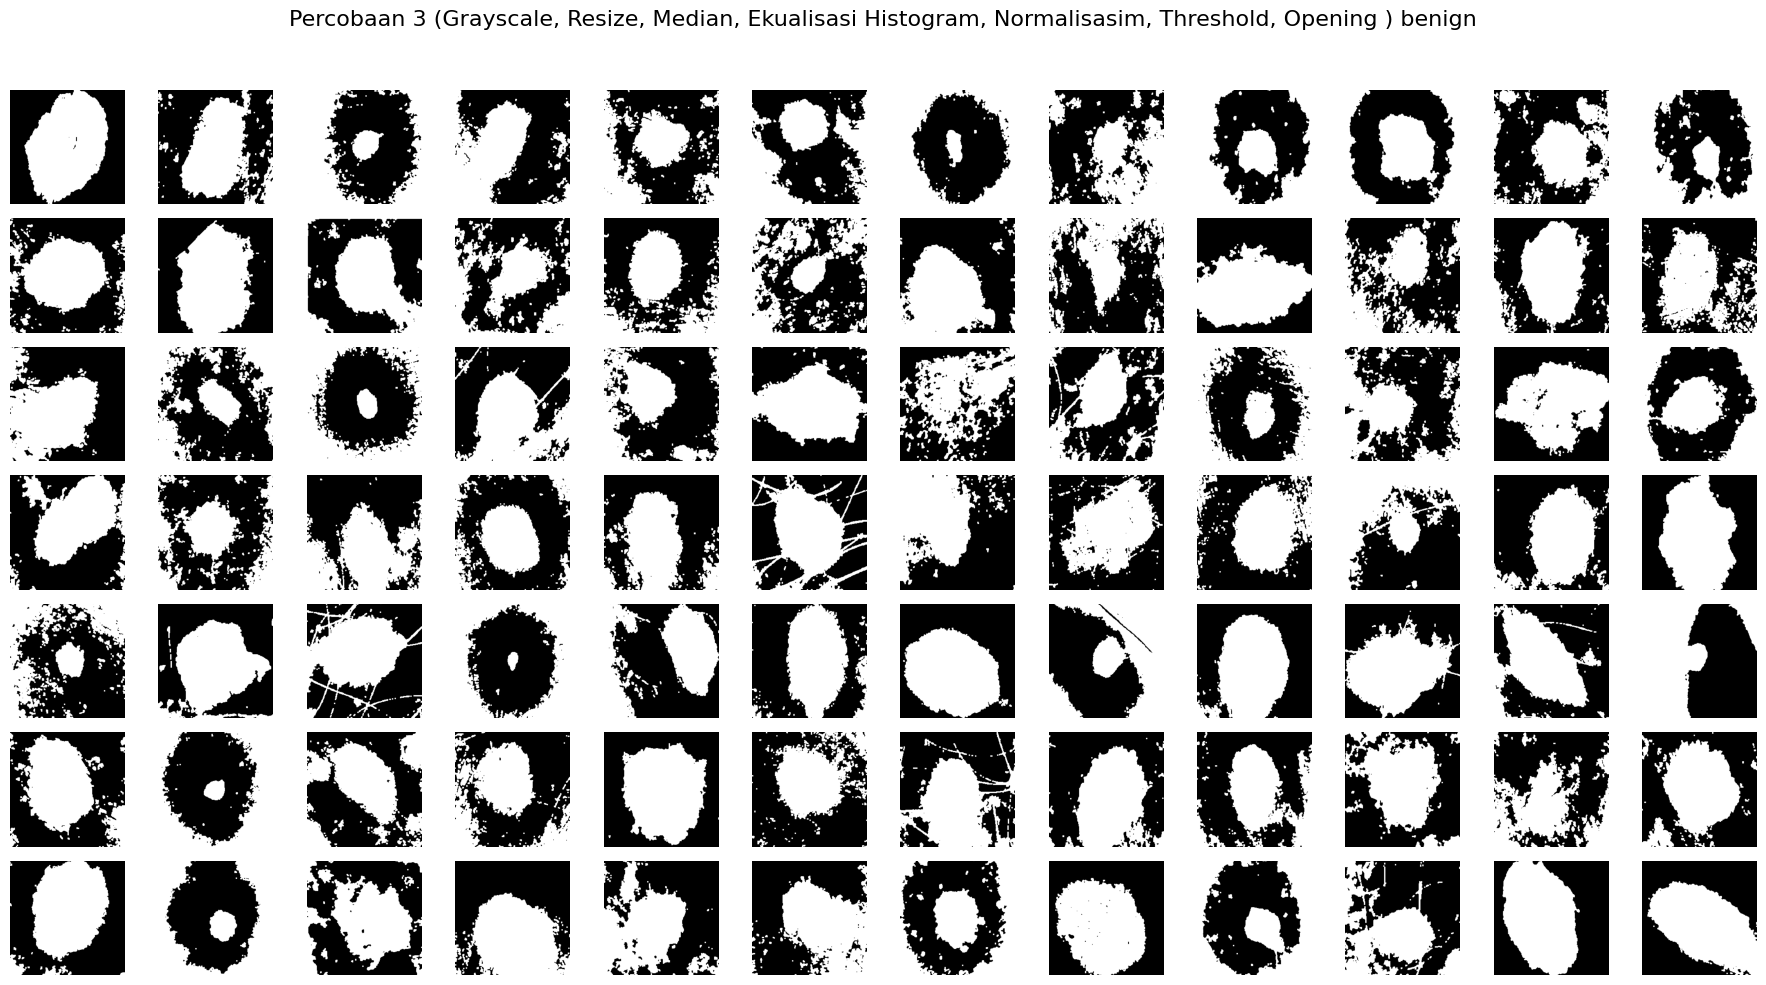

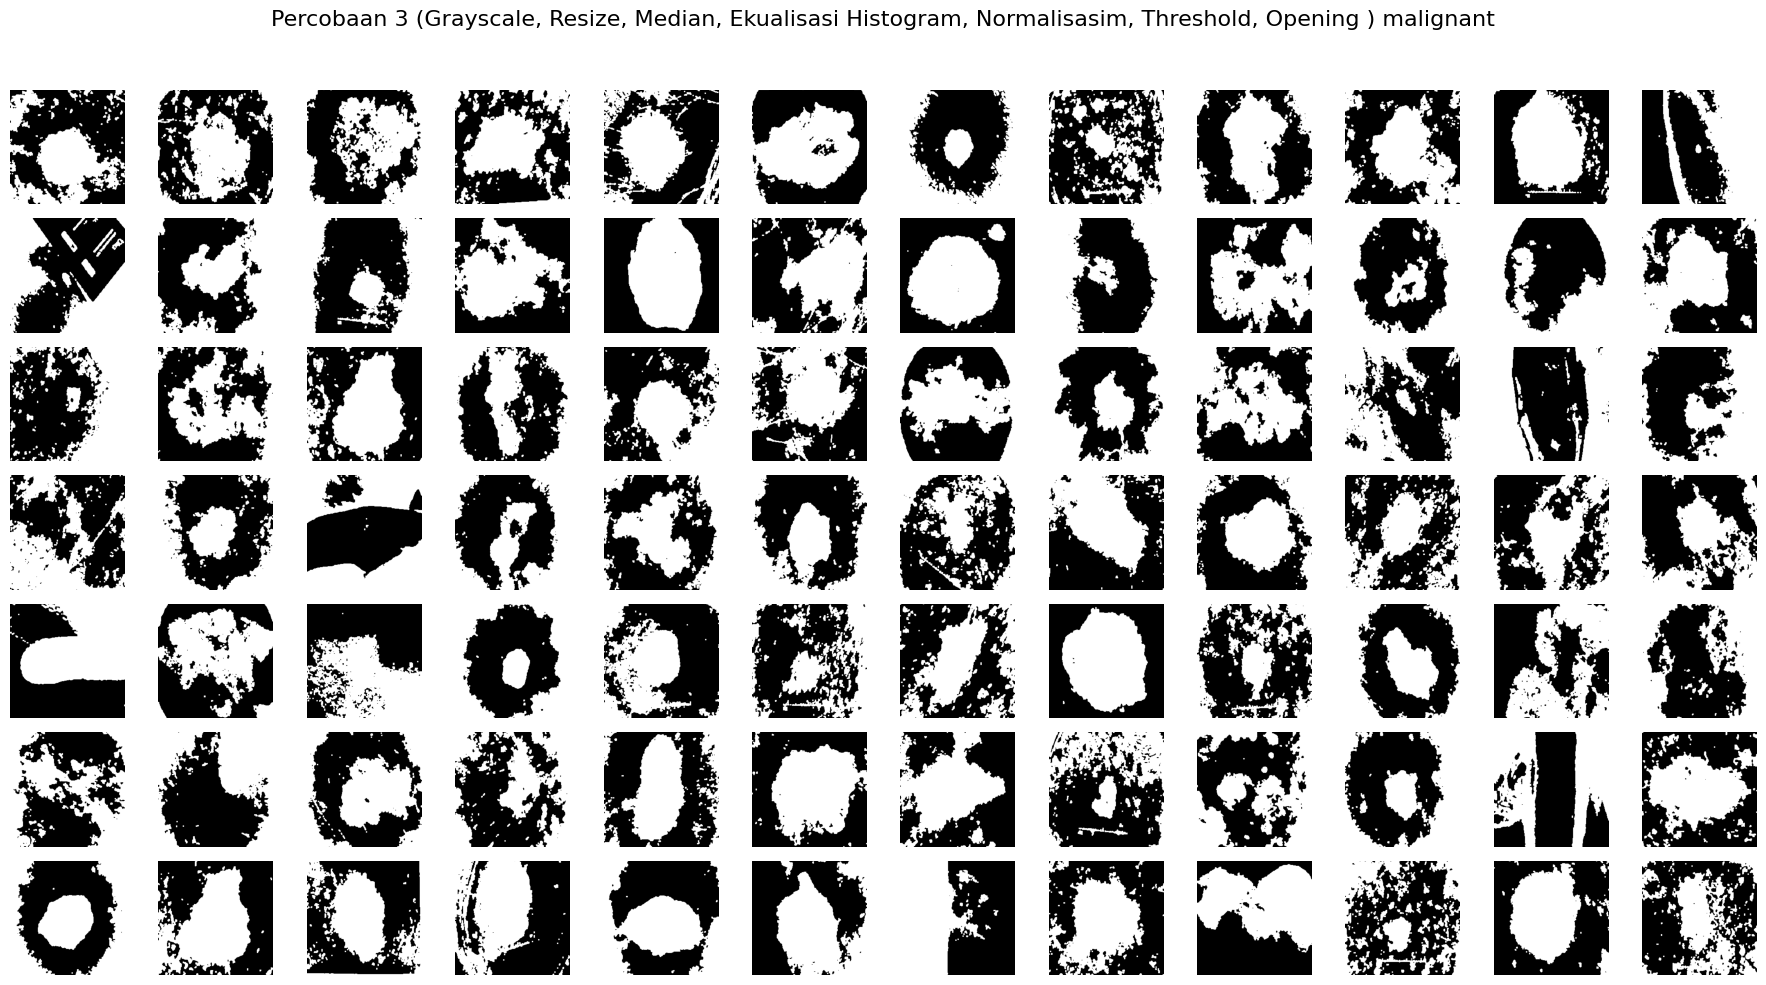

In [34]:
def percobaan_3(img):
    img_rsz = resize(img, 256, 256)
    img_median = median_filter(img_rsz, 3, 3)
    img_eq = histogram_equalization(img_median)
    img_norm = normalize_min_max(img_eq)
    img_thresh = threshold(img_norm, 127)  # Thresholding dengan nilai ambang 127
    img_open = morphological_opening(img_thresh)

    return img_open

dataPreprocessed = [percobaan_3(img) for img in data]  

unique_labels = sorted(set(labels))

for label in unique_labels:
    # Ambil semua indeks gambar dari label ini
    idxs = [j for j, l in enumerate(labels) if l == label]
    
    # Buat grid 7x12 (cukup untuk 84 gambar, 7*12 = 84)
    fig, axs = plt.subplots(7, 12, figsize=(18, 10))
    fig.suptitle(f'Percobaan 3 (Grayscale, Resize, Median, Ekualisasi Histogram, Normalisasim, Threshold, Opening ) {label}', fontsize=16)
    
    for k in range(84):
        row = k // 12
        col = k % 12
        ax = axs[row][col]
        ax.imshow(dataPreprocessed[idxs[k]], cmap='gray')
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.9)  # beri ruang untuk judul
    plt.show()

### Feature Extraction

In [35]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [36]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [37]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [38]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [39]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [40]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [41]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [42]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [43]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [44]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [45]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [46]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [47]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [48]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [49]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [50]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [ ]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

### Write the extraction's results to CSV 

In [52]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_3.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_3.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,1347.jpg,malignant,2365.722656,3411.0,2364.726562,3655.0,0.963619,0.947544,0.963634,0.943792,...,0.473751,0.455623,0.688237,0.677475,0.688296,0.674999,0.925944,0.893234,0.925965,0.885597
1,638.jpg,malignant,2810.976562,3907.0,2343.808594,3901.0,0.956771,0.939916,0.963956,0.940009,...,0.474023,0.452541,0.683905,0.672651,0.688493,0.672712,0.911941,0.877645,0.926624,0.877832
2,1151.jpg,malignant,2696.425781,3628.0,2270.097656,3580.0,0.958533,0.944207,0.965089,0.944945,...,0.467754,0.449572,0.679616,0.670012,0.683925,0.670502,0.916794,0.888055,0.929975,0.889536
3,348.jpg,malignant,2521.113281,3764.0,2244.199219,3370.0,0.961229,0.942115,0.965488,0.948175,...,0.467801,0.451959,0.680996,0.668255,0.683960,0.672279,0.922298,0.883974,0.930819,0.896119
4,360.jpg,malignant,2459.355469,3926.0,2661.562500,3680.0,0.962179,0.939624,0.959069,0.943407,...,0.463477,0.449317,0.682876,0.667814,0.680791,0.670311,0.923944,0.878589,0.917687,0.886197
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
655,635.jpg,benign,1731.210938,2728.0,1817.871094,2607.0,0.973377,0.958048,0.972044,0.959908,...,0.482732,0.471494,0.696013,0.685407,0.694789,0.686654,0.945627,0.914386,0.942957,0.918183
656,147.jpg,benign,1715.273438,2662.0,1697.343750,2387.0,0.973622,0.959063,0.973897,0.963292,...,0.478602,0.468389,0.691608,0.681535,0.691811,0.684390,0.946817,0.917505,0.947371,0.926027
657,806.jpg,benign,1904.531250,2473.0,1499.121094,2632.0,0.970711,0.961969,0.976946,0.959524,...,0.481688,0.465403,0.689924,0.683855,0.694038,0.682205,0.940898,0.923286,0.953499,0.918354
658,1362.jpg,benign,3482.343750,5764.0,2839.863281,3101.0,0.946447,0.911359,0.956327,0.952311,...,0.460328,0.456663,0.671924,0.649070,0.678475,0.675768,0.892426,0.821975,0.912286,0.904223


### Features Selection

pada bagian seleksi fitur ini bisa menggunakan metode seperti
- PCA
- LDA
- t-SNE
- Chi-square
- ANOVA
- Autoencoder
- correlation
- dll

berikut contoh menggunakan correlation:

<Axes: >

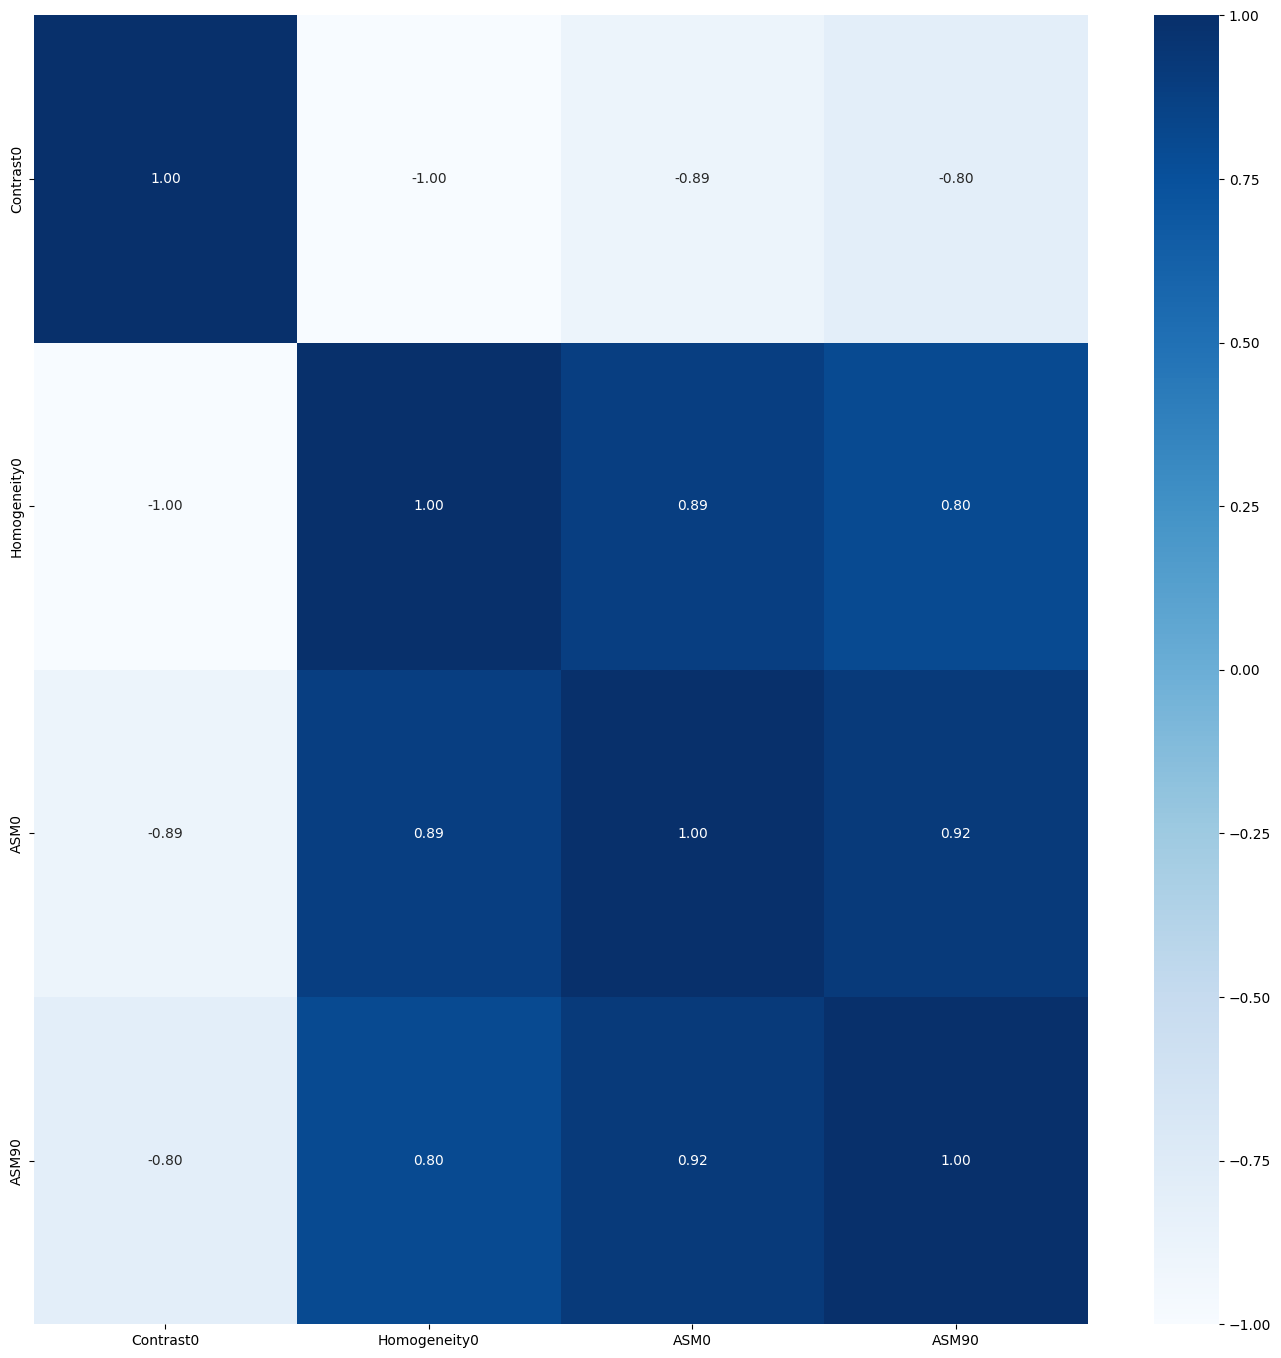

In [53]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

## Splitting Data

In [54]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(528, 4)
(132, 4)


## Feature Normalization

berikut metode normalisasi yang bisa digunakan:
- Min-Max Scaling
- Standardization (Z-score)
- Robust Scaling
- MaxAbsScaler
- dll

berikut contoh menggunakan Standardization (Z-score):

In [55]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

### Define Model

In [56]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

### Train Random Forest Classifier

In [57]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

      benign       0.96      0.98      0.97       294
   malignant       0.97      0.94      0.96       234

    accuracy                           0.96       528
   macro avg       0.97      0.96      0.96       528
weighted avg       0.96      0.96      0.96       528

[[288   6]
 [ 13 221]]
Accuracy: 0.9640151515151515

------Testing Set------
              precision    recall  f1-score   support

      benign       0.60      0.80      0.68        66
   malignant       0.70      0.45      0.55        66

    accuracy                           0.63       132
   macro avg       0.65      0.63      0.62       132
weighted avg       0.65      0.63      0.62       132

[[53 13]
 [36 30]]
Accuracy: 0.6287878787878788


### Train SVM Classifier

In [58]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

      benign       0.68      0.82      0.74       294
   malignant       0.69      0.52      0.60       234

    accuracy                           0.69       528
   macro avg       0.69      0.67      0.67       528
weighted avg       0.69      0.69      0.68       528

[[240  54]
 [112 122]]
Accuracy: 0.6856060606060606

------Testing Set------
              precision    recall  f1-score   support

      benign       0.59      0.77      0.67        66
   malignant       0.67      0.47      0.55        66

    accuracy                           0.62       132
   macro avg       0.63      0.62      0.61       132
weighted avg       0.63      0.62      0.61       132

[[51 15]
 [35 31]]
Accuracy: 0.6212121212121212


### Train KNN Classifier

In [59]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)



------Training Set------
              precision    recall  f1-score   support

      benign       0.76      0.81      0.78       294
   malignant       0.74      0.67      0.70       234

    accuracy                           0.75       528
   macro avg       0.75      0.74      0.74       528
weighted avg       0.75      0.75      0.75       528

[[239  55]
 [ 77 157]]
Accuracy: 0.75

------Testing Set------
              precision    recall  f1-score   support

      benign       0.60      0.73      0.66        66
   malignant       0.65      0.52      0.58        66

    accuracy                           0.62       132
   macro avg       0.63      0.62      0.62       132
weighted avg       0.63      0.62      0.62       132

[[48 18]
 [32 34]]
Accuracy: 0.6212121212121212


## Evaluation With Confusion Matrix

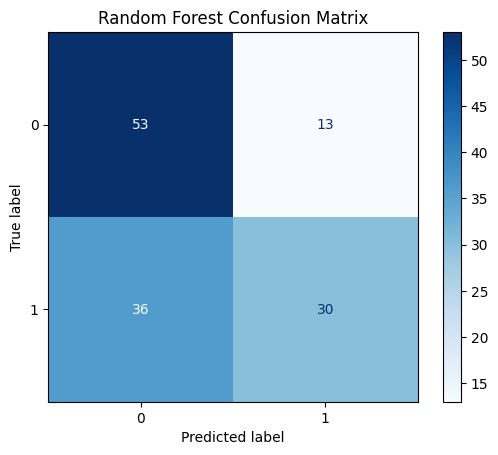

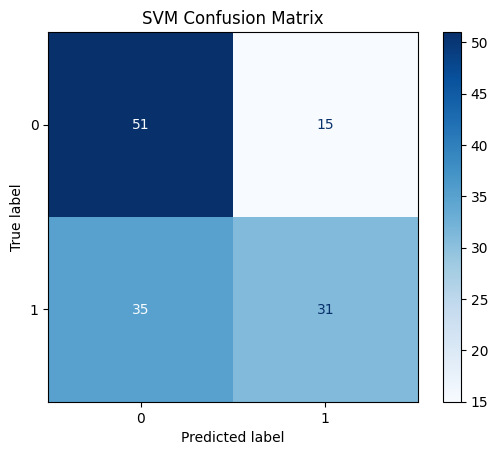

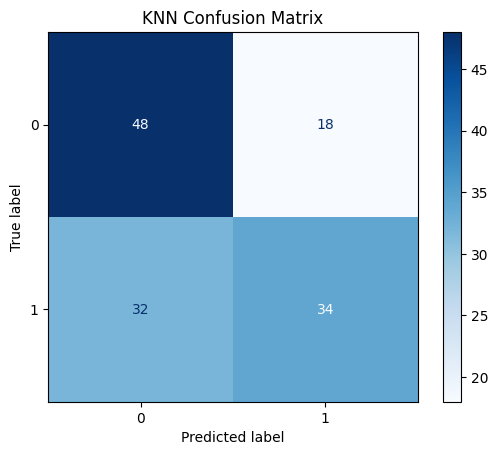

In [60]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")